In [31]:
# モジュールインポート
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from numpy import nan
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_curve, auc, accuracy_score)
import math
import copy

In [32]:

def read_titanic_train():
     return pd.read_csv("../datasets/titanic_train.csv")

def read_titanic_test():
        return pd.read_csv("../datasets/titanic_test.csv")
# read file関連を定義したものの正直関数にする必要はなかったと思いました。
    
def name2int(data):
    # 名前の敬称を元にnameに対応したintとして管理する。
    # WHY : 文字列だと分析する際に利用しにくいため、
    #このような感じで管理。 {'Mrs':0 , 'Miss':1, 'Mr':2,'Master':3, 'その他':4}
    name2int_ary = []
    for name in np.array(data.Name):
        separated_name  = name.split(',')[1]
        if 'Mrs' in separated_name:
            name2int_ary.append(0)
        elif 'Miss' in separated_name:
            name2int_ary.append(1)
        elif 'Mr' in separated_name:
            name2int_ary.append(2)
        elif 'Master' in separated_name:
            name2int_ary.append(3)
        else:
            name2int_ary.append(4)
    data['name2int'] = name2int_ary
    data = data.drop(['Name'],axis=1)        
    return data
# name2int_ary[0:len(name2int_ary)]

# name2intで分類分けした各敬称の年齢の平均の計算用メソッド
##  //// df[df.Name.str.contains("Mr.")].Age.mean()
## とすることで、 Mrの年齢を計算できる。（このメソッド不要だった説。。。作ったので使ってますw）
def avg_name2int(loc, df):
    sum_age = 0
    length = 0
    for age in np.array(df[df['name2int' ]== loc].iloc[:,0:len( np.array(df['name2int']))]['Age']):
        if not math.isnan(age):
             sum_age += age
             length += 1
    avg = sum_age / length
    return  round(avg , 0) 


def embed_age(age_ary, df):
    for i, num in enumerate(age_ary):
        if math.isnan(num):
            if df.iloc[i].name2int == 0:
                df.at[i,'Age'] =  avg_name2int(0,df)
            elif df.iloc[i].name2int == 1:
                df.at[i,'Age'] =  avg_name2int(1,df)
            elif df.iloc[i].name2int == 2:
                df.at[i,'Age'] =  avg_name2int(2,df)
            elif df.iloc[i].name2int == 3:
                df.at[i,'Age'] =  avg_name2int(3,df)
            elif df.iloc[i].name2int == 4:
                df.at[i,'Age'] =  avg_name2int(4,df)
            else: 
                df.at[i,'Age'] = df['Age'].median()


In [33]:
df = read_titanic_train()
# 欠損が多いものを削除
df.drop(['PassengerId',  'Ticket', 'Cabin'], axis=1, inplace=True)

# ムダな文字列の置換とデータの補足 to me
df.Embarked = df.Embarked.replace(['C', 'S', 'Q'], [0, 1, 2])
# Cherbourg: 0 , Queenstown, : 1 , Southampton: 2
df.Sex = df.Sex.replace(['male', 'female'], [0, 1])
# df.Age = df.Age.replace('NaN', 0)

df['Fare'] = df['Fare'].fillna(df['Fare'].median())

#いくつかのカラムを削除。

# df = df.drop(['Cabin','Name','PassengerId','Ticket'],axis=1)



# df['Age'] = df['Age'].fillna(df['Age'].median())
name2int(df)

age_ary =  np.array(df.Age)[0:len( np.array(df.Age))]

embed_age(age_ary, df)
df = df.drop(['Name'],axis=1)



# # print("----------------------------")
# print(f'count : {df.count()}')
# # print("----------------------------")
# print(f'count : {df.dropna().count()}')

##################
## df.isnull().sum()
# Survived      0
# Pclass        0
# Sex           0
# Age         177
# SibSp         0
# Parch         0
# Fare          0
# Embarked      2
# dtype: int64
###################


#  FIXME 年齢は男女別に分けたほうがいいかも   done 
### TODO  ticketで分けてみるのも面白いかも？w  


#TODO  死亡確率がどこの特徴と変動しているかグラフで見た方がいい説。濃厚

In [34]:
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,name2int
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,889.000000,891.000000
mean,0.383838,2.308642,0.352413,29.719607,0.523008,0.381594,32.204208,0.897638,1.607183
std,0.486592,0.836071,0.477990,13.261087,1.102743,0.806057,49.693429,0.515181,0.883376
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000,1.000000
50%,0.000000,3.000000,0.000000,30.000000,0.000000,0.000000,14.454200,1.000000,2.000000
75%,1.000000,3.000000,1.000000,36.000000,1.000000,0.000000,31.000000,1.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,4.000000


In [35]:
# df.head(40)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,name2int
0,0,3,0,22.0,1,0,7.2500,1.0,2
1,1,1,1,38.0,1,0,71.2833,0.0,0
2,1,3,1,26.0,0,0,7.9250,1.0,1
3,1,1,1,35.0,1,0,53.1000,1.0,0
4,0,3,0,35.0,0,0,8.0500,1.0,2


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


([array([  80.,   97.,  372.]), array([ 216.,  184.,  491.])],
 array([ 1.        ,  1.66666667,  2.33333333,  3.        ]),
 <a list of 2 Lists of Patches objects>)

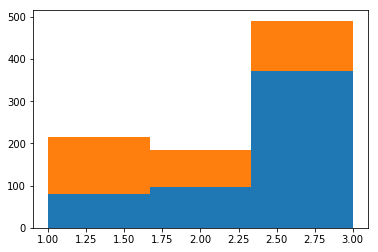

In [36]:
split_data = []
for survived in [0,1]:
    split_data.append(df[df.Survived==survived])

temp = [i["Pclass"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=3)
# 左から一等、二等、三等客室

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


([array([  15.,   13.,    8.,   63.,   94.,   66.,  152.,   42.,   31.,
           23.,   14.,   11.,   10.,    3.,    4.,    0.]),
  array([  48.,   20.,   19.,   96.,  158.,  108.,  207.,   84.,   48.,
           39.,   24.,   18.,   14.,    3.,    4.,    1.])],
 array([  0.42   ,   5.39375,  10.3675 ,  15.34125,  20.315  ,  25.28875,
         30.2625 ,  35.23625,  40.21   ,  45.18375,  50.1575 ,  55.13125,
         60.105  ,  65.07875,  70.0525 ,  75.02625,  80.     ]),
 <a list of 2 Lists of Patches objects>)

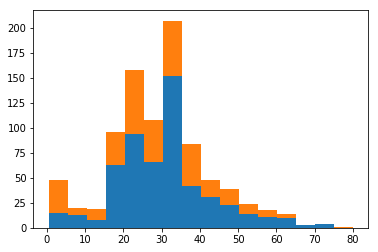

In [37]:
temp = [i["Age"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=16)
# 子供がいきてru ?????????? 
#  -> 子供づれの家族は早めに救助されたとか。
## 高齢者が少ないのはそもそもの分母が少ない気がしている。

In [38]:
# y= np.array(df.loc[:, ['Survived']])

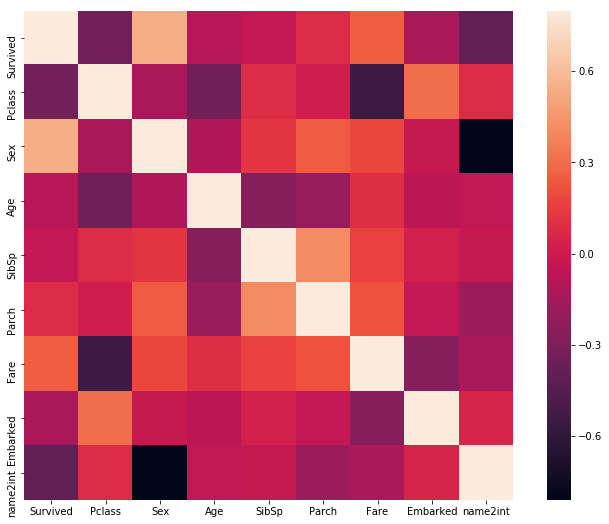

In [39]:
corrmat = df.corr()
corrmat
# 数値見にくい。。。。。。。
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True)
# 性別。。。
# 生死に、ageはあんまり関係してない？→予想と外れている。。。。

##推理：人間的な行動をとることを前提すれば、家族（子供づれ）は子供を守ったりするから生存率が高いような気がした。


In [40]:
df.columns
# Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')
desc_data = df.loc[:,['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
target_column = df.loc[:, ['Survived']]
target_column = np.array(target_column).reshape(-1)
x_train , x_test, y_train, y_test = train_test_split(desc_data, target_column ,test_size=0.3,random_state=0)
x_train = x_train.values.astype(np.int64)
x_test = x_test.values.astype(np.int64)

rfc = RandomForestClassifier(random_state=0, n_estimators=10)
rfc.fit(x_train,y_train)
rfc.score(x_test, y_test)

0.83582089552238803

In [41]:

# データセットの分割
from sklearn.model_selection import train_test_split
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(df,target_column, test_size=0.3, random_state=0)
X_2_train = X_2_train.values.astype(np.int64)

rfc_2 = RandomForestClassifier(random_state=0, n_estimators=100)
rfc_2.fit(X_2_train, y_2_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

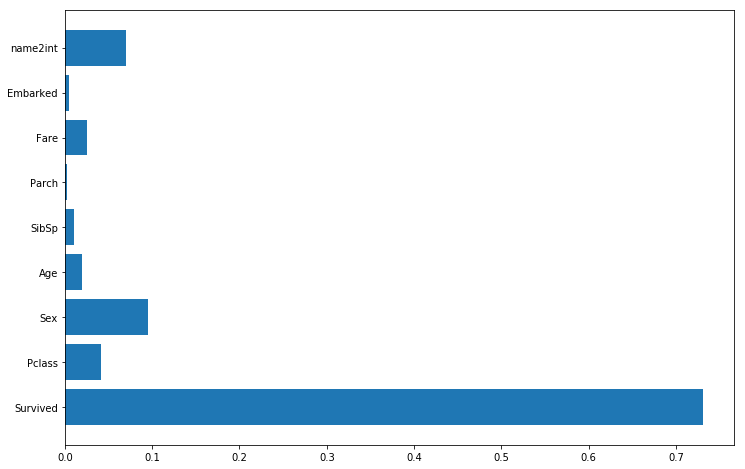

In [42]:
n_features = len(df.columns)
plt.figure(figsize=(12, 8))
plt.barh(range(n_features), rfc_2.feature_importances_ , align='center')
plt.yticks(np.arange(n_features), df.columns)
plt.show()
## 性別。年齢。。。。
## Fare.......? どうしようか。。。。

In [49]:
target = df['Survived'].values
train = copy.deepcopy(df)

## ------------------error--------------------------
# svm = svm.LinearSVC()
# svm.fit(train, target)
# データの加工しないとダメ
# ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
# https://qiita.com/twaka/items/eb3ff958f87ca1f4c971
##########################################

# train.drop('Survived', axis=1, inplace=True)
train = train.values.astype(np.int64)
# svm = svm.LinearSVC()
# svm.fit(train, target)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(train,target)
tree.score

<bound method ClassifierMixin.score of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')>

In [50]:
# df_test =  pd.read_csv("../datasets/titanic_test.csv")
## 本当はこれを使ってkaggleにあげるけど、いったんはローカルで検証していたい。
# df_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# df_test.Embarked = df_test.Embarked.replace(["C", "S","Q"], ["0", "1","2"])
# df_test.Sex = df_test.Sex.replace(['male', 'female'], [0, 1])
# df_test.Age = df_test.Age.replace('NaN', 0)
# #df _test = df_test.values.astype(np.int64)



In [51]:
# #########################################33
# ## 名前の敬称を元に年齢を推測したい
# ############################################

# # 名前の敬称を
# #{'Mrs':0 , 'Miss':1, 'Mr':2,'Master':3, 'その他':4}

# name2int_ary = []
# # a = 'Williams, Mr. Charles Eugene'
# # if 'Mrs' in a:
# #     print('Mr')
# for name in np.array(df2.Name):
#         tmp = name.split(',')[1]
#         if  'Mrs' in tmp:
#             #年上の既婚女性、夫人	
#             name2int_ary.append(0)
#         elif 'Miss' in tmp:
#             #若い未婚女性、お嬢さん
#             name2int_ary.append(1)
#         elif  'Mr' in tmp:
#             #・既婚、未婚関わらず全ての成人男性
#             name2int_ary.append(2)
#         elif 'Master' in tmp:
#             #Master	
#             name2int_ary.append(3)
#         else:
#             name2int_ary.append(4)
#             # don Rev, Dr, Nme, Ms , Major, Col
#             # のような敬称も存在するが微々たる個数のためまとめて管理。    


## defilne  > name2int 
## define  >  embed_age
## ふたつのメソッドの定義にて検証終了。



/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


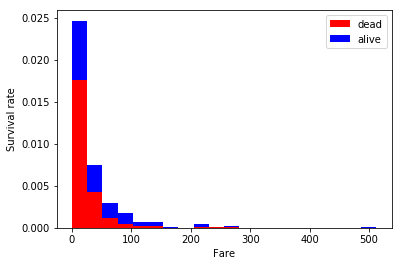

In [53]:
tmp = [i["Fare"].dropna() for i in split_data]
plt.hist(tmp, normed=True, color=['red', 'blue'], label=['dead', 'alive'], histtype='bar', stacked=True, bins=20)
plt.xlabel("Fare")
plt.ylabel("Survival rate")
plt.legend() 
plt.show()
##　。。。果たして大きな影響を及ぼしているのか、。。？
